<a href="https://colab.research.google.com/github/dikshabhati1/Cartoon_classification/blob/main/cartoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dikshabhati2002","key":"027ea99181f9f969ad60b51d93d1a7e9"}'}

In [2]:
#create a new file and move the kaggle file into it
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d skbadhsm/cartoon

 98% 385M/392M [00:03<00:00, 127MB/s]
100% 392M/392M [00:03<00:00, 117MB/s]


In [5]:
!unzip -q "/content/cartoon.zip"

In [6]:
train_path='/content/data/train'
test_path='/content/data/test'

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Conv2D,Flatten,Dropout,MaxPool2D,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from glob import glob
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
folders = glob('/content/data/train/*')
len(folders)

5

In [10]:
img_size = [224,224]

In [11]:
resnet = ResNet50(input_shape=img_size + [3], weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [12]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [13]:
# our layers
x = Flatten()(resnet.output)

In [14]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [15]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [16]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [17]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2100 images belonging to 5 classes.


In [19]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 26 images belonging to 5 classes.


In [20]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/10
66/66 [==============================] - 365s 5s/step - loss: 5.2502 - accuracy: 0.3050 - val_loss: 1.7061 - val_accuracy: 0.5385
Epoch 2/10
66/66 [==============================] - 362s 5s/step - loss: 1.0262 - accuracy: 0.6070 - val_loss: 1.2617 - val_accuracy: 0.5385
Epoch 3/10
66/66 [==============================] - 362s 5s/step - loss: 1.0325 - accuracy: 0.6505 - val_loss: 2.7194 - val_accuracy: 0.5385
Epoch 4/10
66/66 [==============================] - 362s 5s/step - loss: 1.7319 - accuracy: 0.5832 - val_loss: 1.4571 - val_accuracy: 0.5769
Epoch 5/10
66/66 [==============================] - 361s 5s/step - loss: 1.0298 - accuracy: 0.6508 - val_loss: 0.9731 - val_accuracy: 0.6154
Epoch 6/10
66/66 [==============================] - 362s 5s/step - loss: 0.8119 - accuracy: 0.7144 - val_loss: 1.1484 - val_accuracy: 0.6923
Epoch 7/10
66/66 [==============================] - 361s 5s/step - loss: 0.8204 - accuracy: 0.7211 - val_loss: 0.9382 - val_accuracy: 0.6538
Epoch 8/10
66

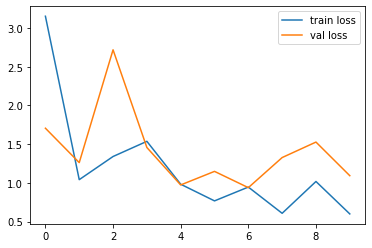

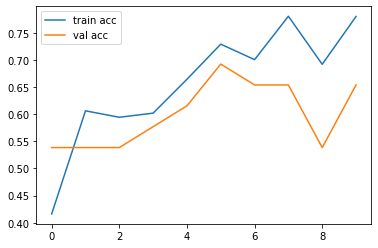

<Figure size 432x288 with 0 Axes>

In [21]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [23]:
# save model
from tensorflow.keras.models import load_model
model.save('model_resnet50.h5')

In [24]:
y_pred = model.predict(test_set)

In [25]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [26]:
y_pred

array([1, 4, 0, 2, 2, 0, 4, 1, 1, 2, 0, 0, 4, 4, 1, 2, 4, 1, 4, 4, 4, 1,
       0, 0, 4, 1])

In [27]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [28]:
model=load_model('model_resnet50.h5')

In [29]:
img=image.load_img('/content/data/test/bean/4.jpg',target_size=(224,224))

In [30]:
x=image.img_to_array(img)

In [32]:
x.shape

(224, 224, 3)

In [33]:
x=x/255

In [34]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [35]:
model.predict(img_data)

array([[5.0790771e-04, 4.1047956e-06, 3.7611328e-06, 1.8671666e-13,
        9.9948418e-01]], dtype=float32)

In [36]:
a=np.argmax(model.predict(img_data), axis=1)

In [37]:
a==4

array([ True])